# Examen Recuperación de la Información

#### **Materia:** Recuperación de la Información
#### **Nombre:** Byron Carpio
#### **Grupo:** GR1CC

In [1]:
# RAG
!pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 48.4 MB/s eta 0:00:00:00:0100:01


In [2]:
# BM25 
!pip install rank_bm25


In [3]:
#Open AI 

import os
from openai import OpenAI

#Obtenemos el secret_key
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
api_key = user_secrets.get_secret("key") 

# Inicializamos el cliente de OpenAI
client = OpenAI(api_key=api_key)

# Creamos la petición al modelo GPT
response = client.responses.create(
    model="gpt-4.1",
    input="Write a one-sentence bedtime story about a unicorn."
)

print(response.output_text)

Under a sparkling midnight sky, a gentle unicorn tiptoed through the whispering meadow, weaving dreams of magic and moonbeams for all the sleeping stars.


In [46]:
import json
import pandas as pd
import faiss
import numpy as np
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


# TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

#BM25
from rank_bm25 import BM25Okapi

# FAISS
from sentence_transformers import SentenceTransformer
import faiss

# Metodo Interactivo 

from IPython.display import FileLink

# Graficos
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler



In [5]:
# Ruta al archivo en Kaggle
file_path = "/kaggle/input/arxiv/arxiv-metadata-oai-snapshot.json"

# Leer 1% de líneas del archivo original
subset_size = int(0.01 * 1700000) 
subset = []

with open(file_path, 'r') as f:
    for _, line in zip(range(subset_size), f):
        data = json.loads(line)
        subset.append({
            "id": data.get("id"),
            "title": data.get("title"),
            "abstract": data.get("abstract")
        })

# Eliminar documentos incompletos
df = pd.DataFrame(subset).dropna()

# Guardar como archivo JSONL
output_path = "/kaggle/working/arxiv_examen.json"
df.to_json(output_path, orient="records", lines=True, force_ascii=False)

print(f"Archivo guardado en: {output_path}")

Archivo guardado en: /kaggle/working/arxiv_examen.json


In [6]:
# Cargar archivo JSONL
file_path = "/kaggle/working/arxiv_examen.json"

with open(file_path, "r") as f:
    data = [json.loads(line) for line in f]

df = pd.DataFrame(data)
df = df[["id", "title", "abstract"]].dropna()
df

,id,title,abstract
0,0704.0001,Calculation of prompt diphoton production cros...,A fully differential calculation in perturba...
1,0704.0002,Sparsity-certifying Graph Decompositions,"We describe a new algorithm, the $(k,\ell)$-..."
2,0704.0003,The evolution of the Earth-Moon system based o...,The evolution of Earth-Moon system is descri...
3,0704.0004,A determinant of Stirling cycle numbers counts...,We show that a determinant of Stirling cycle...
4,0704.0005,From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...,In this paper we show how to compute the $\L...
...,...,...,...
16995,0707.3825,Emergence of noncollinear magnetic ordering in...,Using first-principles density functional ca...
16996,0707.3826,More hilltop inflation models,"Using analytic expressions, we explore the p..."
16997,0707.3827,Engineering Silicon Nanocrystals: Theoretical ...,We show that the optical and electronic prop...
16998,0707.3828,"Structure, bonding and magnetism in cobalt clu...","The structural, electronic and magnetic prop..."


## Preprocesamiento 

In [15]:
# Descargar recursos de NLTK si no están ya
#nltk.download("punkt")
#nltk.download("stopwords")

# Preparar stopwords en inglés
stop_words = set(stopwords.words("english"))

# Procesamiento
def preprocess(text):
    text = text.lower()  # minúsculas
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)  # eliminar puntuación
    tokens = word_tokenize(text)  # tokenizar
    tokens = [t for t in tokens if t not in stop_words]  # eliminar stopwords
    return " ".join(tokens)

# Aplicar a 'title' y 'abstract' 
df["tokens_title"] = df["title"].apply(preprocess)
df["tokens_abstract"] = df["abstract"].apply(preprocess)

# Combinar para indexar
df["text"] = df["tokens_title"] + " " + df["tokens_abstract"]

# Mostrar DataFrame con nuevas columnas
df[["id", "title", "abstract", "text"]].head()

,id,title,abstract,text
0,0704.0001,Calculation of prompt diphoton production cros...,A fully differential calculation in perturba...,calculation prompt diphoton production cross s...
1,0704.0002,Sparsity-certifying Graph Decompositions,"We describe a new algorithm, the $(k,\ell)$-...",sparsitycertifying graph decompositions descri...
2,0704.0003,The evolution of the Earth-Moon system based o...,The evolution of Earth-Moon system is descri...,evolution earthmoon system based dark matter f...
3,0704.0004,A determinant of Stirling cycle numbers counts...,We show that a determinant of Stirling cycle...,determinant stirling cycle numbers counts unla...
4,0704.0005,From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...,In this paper we show how to compute the $\L...,dyadic lambdaalpha lambdaalpha paper show comp...


In [16]:
#Verificamos el texto
print(df["text"].iloc[0][:1000])

calculation prompt diphoton production cross sections tevatron lhc energies fully differential calculation perturbative quantum chromodynamics presented production massive photon pairs hadron colliders nexttoleading order perturbative contributions quarkantiquark gluonantiquark gluongluon subprocesses included well allorders resummation initialstate gluon radiation valid nexttonexttoleading logarithmic accuracy region phase space specified calculation reliable good agreement demonstrated data fermilab tevatron predictions made detailed tests cdf data predictions shown distributions diphoton pairs produced energy large hadron collider lhc distributions diphoton pairs decay higgs boson contrasted produced qcd processes lhc showing enhanced sensitivity signal obtained judicious selection events


## Indexación

In [18]:
# TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

# Crear vectorizador TF–IDF
tfidf_vectorizer = TfidfVectorizer()

# Ajustar y transformar el texto indexable
tfidf_matrix = tfidf_vectorizer.fit_transform(df["text"])

# Convertir la matriz dispersa a DataFrame
df_tfidf = pd.DataFrame(
    tfidf_matrix.T.todense(),  # transponer para que los términos estén en las filas
    index=tfidf_vectorizer.get_feature_names_out(),  # términos
    columns=[f'Doc_{i}' for i in range(tfidf_matrix.shape[0])]  # nombres de documentos
)

# Mostrar las primeras filas de la matriz TF–IDF
#df_tfidf.head(10)

In [26]:
# BM25
from rank_bm25 import BM25Okapi

bm25_corpus = [text.split() for text in df["text"]] 
bm25 = BM25Okapi(bm25_corpus)


In [19]:
# FAISS

# Modelo de embeddings
model = SentenceTransformer("all-MiniLM-L6-v2")

# Generar vectores del corpus
embeddings = model.encode(df["text"], show_progress_bar=True)

# Crear índice FAISS
dimension = embeddings.shape[1]
faiss_index = faiss.IndexFlatL2(dimension)
faiss_index.add(embeddings)

# Convertir embeddings a DataFrame
df_embeddings = pd.DataFrame(
    embeddings,
    index=[f'Doc_{i}' for i in range(len(embeddings))]
)

# Mostrar primeras filas (cada fila es un documento, columnas son dimensiones del vector)
df_embeddings.head(10)


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/532 [00:00<?, ?it/s]

,0,1,2,3,4,5,6,7,8,9,...,374,375,376,377,378,379,380,381,382,383
Doc_0,-0.104759,-0.001585,0.014967,0.034740,-0.002428,-0.031503,-0.081405,0.056200,-0.010155,-0.028389,...,-0.055037,0.023555,-0.011446,-0.039736,0.027976,-0.054230,0.113986,-0.017177,-0.034228,0.066166
Doc_1,-0.005846,0.035885,0.032471,-0.083078,-0.040409,-0.061329,0.018042,-0.110752,-0.051789,0.042603,...,-0.023732,0.025122,-0.018440,0.025882,0.113177,-0.039053,-0.006976,-0.013120,0.007371,0.066057
Doc_2,-0.035634,-0.057915,0.056979,0.011660,0.065877,-0.056268,-0.159028,0.066141,-0.049563,0.005363,...,0.065710,-0.019034,-0.020544,0.061409,0.004505,-0.032067,0.024092,-0.041619,-0.040397,0.026851
Doc_3,-0.034201,-0.005540,-0.042189,-0.006602,-0.062896,0.091087,0.044093,-0.056306,-0.045274,-0.054045,...,-0.006035,-0.006398,0.001742,0.021560,0.109941,0.101768,-0.009550,0.103490,0.017578,0.012752
Doc_4,0.006758,0.001423,-0.045264,-0.023234,-0.021212,0.067915,0.054182,0.001973,0.017685,-0.044654,...,-0.105384,-0.045450,-0.093322,-0.018805,-0.012694,-0.007279,0.053717,0.039517,0.036442,-0.026097
Doc_5,-0.028118,-0.030682,-0.057978,0.021879,-0.060853,0.071346,-0.025720,0.001216,0.018213,-0.082991,...,-0.085427,0.023798,-0.069108,-0.014047,0.078083,-0.033137,0.012139,-0.009801,-0.024652,-0.038304
Doc_6,-0.069442,-0.050347,0.014360,-0.014585,-0.068765,0.058191,-0.061668,0.061555,0.008897,-0.017623,...,-0.043457,0.094329,-0.056412,-0.040752,-0.023945,0.002403,0.024644,-0.032049,0.034227,0.124777
Doc_7,-0.099822,0.036989,0.096285,0.057917,-0.027639,-0.064301,-0.092420,0.106326,-0.094575,0.001296,...,0.067113,0.009323,-0.070659,-0.012030,0.026718,-0.026228,0.052433,-0.058336,0.004161,0.000513
Doc_8,0.030477,-0.084215,0.075595,-0.000415,0.011470,-0.087287,-0.056020,0.019324,-0.015403,0.030740,...,-0.064005,0.043921,-0.008107,0.062909,0.086335,0.045614,0.122506,-0.038220,-0.082945,0.062478
Doc_9,0.016999,0.022289,-0.018268,-0.030063,-0.100682,-0.036804,-0.025419,-0.036054,-0.025997,-0.023605,...,0.014121,0.036744,-0.030255,-0.017472,0.039562,-0.027656,0.001080,0.039812,0.014850,0.014876


## Recuperación

In [20]:
def preprocess_query(query):
    query = query.lower()
    query = re.sub(f"[{re.escape(string.punctuation)}]", "", query)
    tokens = word_tokenize(query)
    tokens = [w for w in tokens if w not in stop_words]
    return " ".join(tokens), tokens

In [31]:
def search_tfidf(query, top_k=10):
    query_text, _ = preprocess_query(query)
    q_vec = tfidf_vectorizer.transform([query_text])
    scores = (tfidf_matrix @ q_vec.T).toarray().ravel()
    top_indices = scores.argsort()[-top_k:][::-1]

    # Extraer las columnas y los scores por separado
    ids = df.iloc[top_indices]["id"].values
    titles = df.iloc[top_indices]["title"].values
    abstracts = df.iloc[top_indices]["abstract"].values
    top_scores = [scores[i] for i in top_indices]

    # Crear nuevo DataFrame con score incluido
    results_df = pd.DataFrame({
        "id": ids,
        "title": titles,
        "abstract": abstracts,
        "score": top_scores
    })

    return results_df

In [33]:
def search_bm25(query, top_k=10):
    _, query_tokens = preprocess_query(query)
    scores = bm25.get_scores(query_tokens)
    top_indices = np.argsort(scores)[-top_k:][::-1]

    ids = df.iloc[top_indices]["id"].values
    titles = df.iloc[top_indices]["title"].values
    abstracts = df.iloc[top_indices]["abstract"].values
    top_scores = [scores[i] for i in top_indices]

    results_df = pd.DataFrame({
        "id": ids,
        "title": titles,
        "abstract": abstracts,
        "score": top_scores
    })

    return results_df


In [35]:
# FAISS
def search_faiss(query, top_k=10):
    query_text, _ = preprocess_query(query)
    q_vec = model.encode([query_text])
    D, I = faiss_index.search(np.array(q_vec), top_k)

    indices = I[0]
    distances = D[0]

    # Convertir distancias a similitud (score)
    scores = 1 / (1 + distances)

    # Extraer columnas del DataFrame original
    ids = df.iloc[indices]["id"].values
    titles = df.iloc[indices]["title"].values
    abstracts = df.iloc[indices]["abstract"].values

    # Construir DataFrame de resultados con score
    results_df = pd.DataFrame({
        "id": ids,
        "title": titles,
        "abstract": abstracts,
        "score": scores
    })

    # Ordenar de mayor a menor similitud
    return results_df.sort_values(by="score", ascending=False)


In [37]:
# Consultas 

consulta = "The evolution of the Earth-Moon"

print("Resultados con TF–IDF:")
display(search_tfidf(consulta))

print("Resultados con BM25:")
display(search_bm25(consulta))

print("Resultados con FAISS:")
display(search_faiss(consulta))


Resultados con TF–IDF:


,id,title,abstract,score
0,0704.0003,The evolution of the Earth-Moon system based o...,The evolution of Earth-Moon system is descri...,0.624284
1,0705.2393,Observing the evolution of a quantum system th...,This article deals with the problem of gathe...,0.178646
2,0705.3421,On the Formation and Dynamical Evolution of Pl...,Among the extrasolar planetary systems about...,0.116939
3,0705.4235,Spin evolution of spin-1 Bose-Einstein condens...,An analytical formula is obtained to describ...,0.108723
4,0704.3083,Late stages of stellar evolution and their imp...,The connection between AGB evolution of stel...,0.108613
5,0707.0339,The BSSN formulation is a partially constraine...,Relativistic simulations in 3+1 dimensions t...,0.103267
6,0704.0341,Infrared Evolution Equations: Method and Appli...,It is a brief review on composing and solvin...,0.102314
7,0704.0612,Solving The High Energy Evolution Equation Inc...,We study the solution of the nonlinear BK ev...,0.100888
8,0705.2315,On the Connection between Mass Loss and Evolut...,The mass loss properties of carbon AGB stars...,0.099605
9,0704.2541,Gamma-ray probe of the QSO's obscured evolution,The idea that substantial absorption in AGN ...,0.098081


Resultados con BM25:


,id,title,abstract,score
0,0704.0003,The evolution of the Earth-Moon system based o...,The evolution of Earth-Moon system is descri...,21.019846
1,0705.1046,"Determination of the size, mass, and density o...",Precise photometric measurements of the upco...,6.439404
2,0705.2393,Observing the evolution of a quantum system th...,This article deals with the problem of gathe...,5.668148
3,0707.0339,The BSSN formulation is a partially constraine...,Relativistic simulations in 3+1 dimensions t...,5.296792
4,0705.3421,On the Formation and Dynamical Evolution of Pl...,Among the extrasolar planetary systems about...,5.196190
5,0704.3083,Late stages of stellar evolution and their imp...,The connection between AGB evolution of stel...,5.195255
6,0705.2973,Partially coherent matter wave and its evolution,The evolution and propagation of a partially...,5.195255
7,0704.0612,Solving The High Energy Evolution Equation Inc...,We study the solution of the nonlinear BK ev...,5.140924
8,0705.2299,Time evolution of T_{\mu\nu} and the cosmologi...,We study the cosmic time evolution of an eff...,5.082387
9,0704.0259,Formation and Collisional Evolution of Kuiper ...,This chapter summarizes analytic theory and ...,5.076299


Resultados con FAISS:


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

,id,title,abstract,score
0,0704.0003,The evolution of the Earth-Moon system based o...,The evolution of Earth-Moon system is descri...,0.478814
1,0705.1075,Diversity Begets Stability in an Evolving Network,Complex evolving systems such as the biosphe...,0.468301
2,0705.3157,Two evolutionary lineages: Machiavellian and B...,Two evolutionary lineages: Machiavellian and...,0.456578
3,0706.1089,Geochemistry of U and Th and its Influence on ...,We have investigated the migration behaviors...,0.456547
4,0705.3176,Analysis of evidence of Mars life,"Gillevinia straata, the scientific name [1, ...",0.455768
5,0704.0304,The World as Evolving Information,This paper discusses the benefits of describ...,0.455749
6,0705.2562,Anthropic prediction in a large toy landscape,The successful anthropic prediction of the c...,0.455199
7,0706.0156,A Cross-disciplinary Framework for the Descrip...,We present a mathematical framework (referre...,0.447778
8,0704.0598,Evolutionary Neural Gas (ENG): A Model of Self...,Despite their claimed biological plausibilit...,0.447447
9,0707.3385,DARWIN mission proposal to ESA,The discovery of extra-solar planets is one ...,0.443749


## RAG

#### Primera forma del RAG, donde la query es fija

In [38]:
def rag(query, top_k=3, model="gpt-4.1"):
    top_docs = search_faiss(query, top_k=top_k)
    context = top_docs["abstract"].tolist()

    prompt = f"""
    Eres una aplicación de Retrieval Augmented Generation que siempre responde en español.
    Usa el siguiente contexto para responder a la pregunta del usuario.
    Si la respuesta no se encuentra en el contexto, responde "No tengo suficiente información para responder a esa pregunta".

    Contexto:
    {context}

    Pregunta:
    El usuario está preguntando sobre "{query}".
    """

    response = client.responses.create(
        model=model,
        input=prompt
    )

    return response.output_text


In [40]:
respuesta = rag("The evolution of the Earth-Moon")
print(respuesta)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

La evolución del sistema Tierra-Luna se describe mediante el modelo de campo fluido de materia oscura, propuesto en la Reunión de la División de Partículas y Campos de la Sociedad Americana de Física en 2004. El comportamiento actual del sistema Tierra-Luna concuerda muy bien con este modelo, y el patrón general de la evolución del sistema Luna-Tierra que describe coincide con evidencias geológicas y fósiles.

Según este modelo, la distancia más cercana de la Luna a la Tierra fue de aproximadamente 259,000 km hace 4.5 mil millones de años, lo cual está muy por encima del límite de Roche. El resultado sugiere que la fricción de marea puede no ser la causa principal de la evolución del sistema Tierra-Luna. Además, la constante promedio del campo fluido de materia oscura derivada de los datos del sistema Tierra-Luna es de 4.39 x 10^(-22) s^(-1)m^(-1).


#### Segunda forma del RAG, de manera Interactiva, tambien se implementó la salida de audio

In [48]:
# Metodo Interactivo
while True:
    query = input("\nIngresa tu pregunta (o escribe 'salir' para terminar): ")
    if query.lower() in ['salir', 'exit', 'quit']:
        print("Sesión finalizada.")
        break

    # Recuperar documentos relevantes con tu función FAISS
    top_docs = search_faiss(query, top_k=3)  # Usa tu función ya definida
    contexto = "\n\n".join(top_docs["abstract"].tolist())

    # Construir el prompt para el modelo
    prompt = f"""
Eres una aplicación de Retrieval Augmented Generation que siempre responde en español.
Usa el siguiente contexto para responder a la pregunta del usuario.
Si la respuesta no se encuentra en el contexto, responde "No tengo suficiente información para responder a esa pregunta".

Contexto:
{contexto}

Pregunta:
El usuario está preguntando sobre: "{query}"
"""

    # Llamada al modelo de OpenAI Chat (puede ser gpt-4.1, gpt-4.1-mini, etc.)
    response = client.chat.completions.create(
        model="gpt-4.1-mini",
        messages=[
            {"role": "system", "content": "Responde en español solo usando el contexto proporcionado."},
            {"role": "user", "content": prompt}
        ]
    )

    # Obtener la respuesta de texto
    respuesta_texto = response.choices[0].message.content
    print("\nRespuesta del modelo:")
    print(respuesta_texto)

    # Generar audio con OpenAI TTS
    tts_response = client.audio.speech.create(
        model="tts-1",
        voice="alloy",  # Opciones: alloy, onyx, nova, shimmer, fable, echo
        input=respuesta_texto
    )

    # Guardar como archivo MP3
    audio_filename = "respuesta.mp3"
    with open(audio_filename, "wb") as f:
        f.write(tts_response.content)

    # Mostrar enlace de descarga del audio
    print("\nAudio generado:")
    display(FileLink(audio_filename))


Ingresa tu pregunta (o escribe 'salir' para terminar):  The evolution of the Earth-Moon


Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Respuesta del modelo:
La evolución del sistema Tierra-Luna está descrita por el modelo de fluido del campo de materia oscura, propuesto en la Reunión de la División de Partículas y Campos de 2004 de la American Physical Society. El comportamiento actual del sistema Tierra-Luna concuerda muy bien con este modelo y el patrón general de su evolución está en acuerdo con evidencias geológicas y fósiles. Hace aproximadamente 4.5 mil millones de años, la distancia más cercana de la Luna a la Tierra fue de alrededor de 259,000 km, una distancia muy superior al límite de Roche. Esto sugiere que la fricción de marea puede no ser la causa principal de la evolución del sistema Tierra-Luna. Además, el modelo deriva una constante promedio del fluido de campo de materia oscura a partir de los datos del sistema Tierra-Luna, cuyo valor es 4.39 x 10^(-22) s^(-1)m^(-1).

Audio generado:


/kaggle/working/respuesta.mp3


Ingresa tu pregunta (o escribe 'salir' para terminar):  salir


Sesión finalizada.


## Evaluación

#### Grafico de la Relevancia por Top 10

In [49]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

def comparar_modelos(query, top_k=5):
    # Obtener resultados por modelo
    tfidf_res = search_tfidf(query, top_k=top_k)
    bm25_res = search_bm25(query, top_k=top_k)
    faiss_res = search_faiss(query, top_k=top_k)

    # Etiquetar modelo
    tfidf_res["modelo"] = "TF-IDF"
    bm25_res["modelo"] = "BM25"
    faiss_res["modelo"] = "FAISS"

    # Normalizar scores para comparabilidad
    scaler = MinMaxScaler()
    tfidf_res["score_norm"] = scaler.fit_transform(tfidf_res[["score"]])
    bm25_res["score_norm"] = scaler.fit_transform(bm25_res[["score"]])
    faiss_res["score_norm"] = scaler.fit_transform(faiss_res[["score"]])

    # Combinar resultados
    resultados = pd.concat([tfidf_res, bm25_res, faiss_res], ignore_index=True)

    # Crear etiquetas para el eje X
    resultados["etiqueta"] = resultados["modelo"] + " - " + resultados["id"].astype(str)

    # Configurar colores por modelo
    palette = {
        "TF-IDF": "#1f77b4",   
        "BM25": "#ff7f0e",     
        "FAISS": "#2ca02c"    
    }

    # Crear gráfico
    plt.figure(figsize=(14, 6))
    sns.barplot(data=resultados, x="etiqueta", y="score_norm", hue="modelo", palette=palette)

    plt.title(f"Comparación de relevancia normalizada para: '{query}'")
    plt.ylabel("Score normalizado")
    plt.xlabel("Documento por modelo")
    plt.xticks(rotation=45, ha="right")
    plt.legend(title="Modelo")
    plt.tight_layout()
    plt.grid(axis="y")
    plt.show()


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

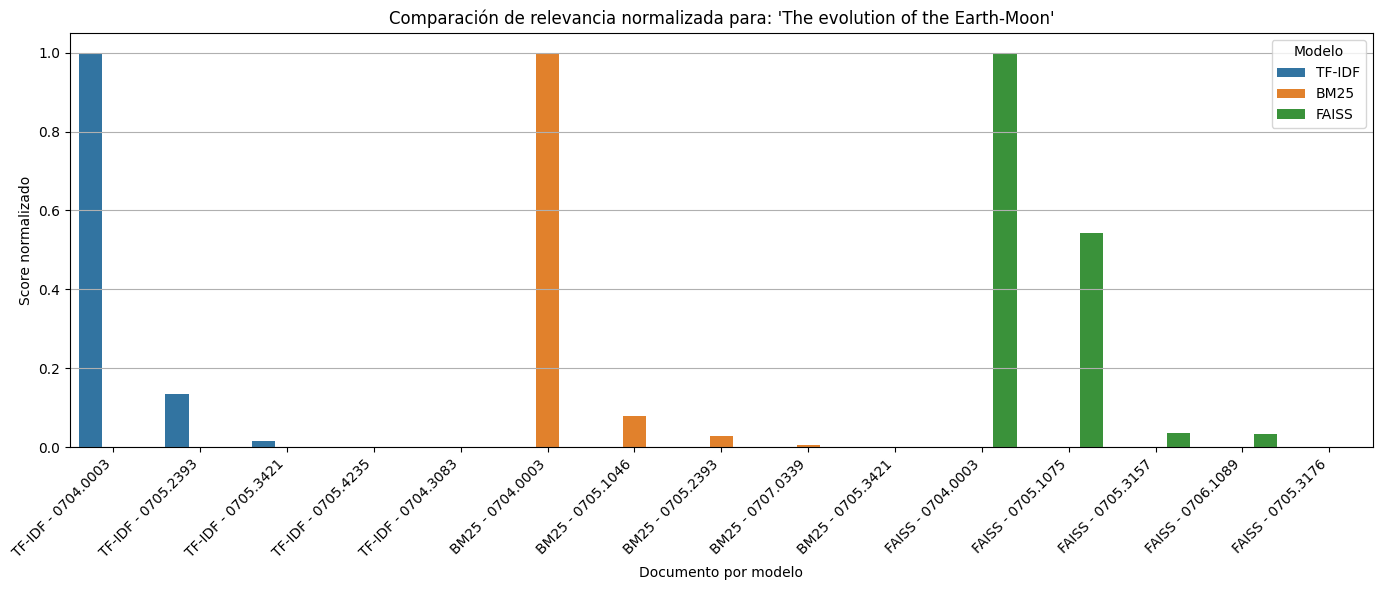

In [50]:
query = "The evolution of the Earth-Moon"
comparar_modelos(query)


#### Comparación de Modelos

In [65]:
def comparar_rankings(query, top_k=10):
    # Obtenemos resultados
    tfidf_res = search_tfidf(query, top_k=top_k)
    bm25_res = search_bm25(query, top_k=top_k)
    faiss_res = search_faiss(query, top_k=top_k)

    # Extraemos IDs
    tfidf_ids = tfidf_res["id"].tolist()
    bm25_ids = bm25_res["id"].tolist()
    faiss_ids = faiss_res["id"].tolist()

    # Convertir a sets
    tfidf_set = set(tfidf_ids)
    bm25_set = set(bm25_ids)
    faiss_set = set(faiss_ids)

    # Documentos en común
    inter_tfidf_bm25 = tfidf_set & bm25_set
    inter_tfidf_faiss = tfidf_set & faiss_set
    inter_bm25_faiss = bm25_set & faiss_set
    inter_all = tfidf_set & bm25_set & faiss_set

    print(f"\nTF-IDF & BM25: {len(inter_tfidf_bm25)} documentos en común")
    print(f"TF-IDF & FAISS: {len(inter_tfidf_faiss)} documentos en común")
    print(f"BM25 & FAISS: {len(inter_bm25_faiss)} documentos en común")
    print(f"Común entre los tres modelos: {len(inter_all)} documentos")

    if inter_all:
        print("\nDocumentos comunes en los tres modelos:\n")
        for doc_id in inter_all:
            titulo = df[df["id"] == doc_id]["title"].values[0]
            print(f"📄 {doc_id}: {titulo}")
    else:
        print("\nNo hay documentos comunes en los tres modelos.")

    # Comparamos Ranking
    ranking_overlap = {
        "TF-IDF vs BM25": len(set(tfidf_ids) & set(bm25_ids)),
        "TF-IDF vs FAISS": len(set(tfidf_ids) & set(faiss_ids)),
        "BM25 vs FAISS": len(set(bm25_ids) & set(faiss_ids)),
        "Documento similar (3 Métodos)": len(set(tfidf_ids) & set(bm25_ids) & set(faiss_ids))
    }

    return {
        "TF-IDF": tfidf_ids,
        "BM25": bm25_ids,
        "FAISS": faiss_ids,
        "overlap": ranking_overlap
    }

In [66]:
query = "The evolution of the Earth-Moon"
resultados_comparacion = comparar_rankings(query)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


TF-IDF & BM25: 6 documentos en común
TF-IDF & FAISS: 1 documentos en común
BM25 & FAISS: 1 documentos en común
Común entre los tres modelos: 1 documentos

Documentos comunes en los tres modelos:

📄 0704.0003: The evolution of the Earth-Moon system based on the dark matter field
  fluid model
